In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os

# --- Ensure this is set correctly based on your input ---
PREVIOUS_NOTEBOOK_OUTPUT_BASE = '/kaggle/input/cvml_proj'

# --- Paths to check ---
dir_to_check_1 = os.path.join(PREVIOUS_NOTEBOOK_OUTPUT_BASE, 'module_1_outputs')
dir_to_check_2 = os.path.join(PREVIOUS_NOTEBOOK_OUTPUT_BASE, 'module_2_outputs')
file_to_check = os.path.join(dir_to_check_2, 'mobilenetv2_tfdata_best.keras') # Example file

print(f"--- Verifying Input Structure for '{PREVIOUS_NOTEBOOK_OUTPUT_BASE}' ---")

# Check if base input exists
print(f"Base input path '{PREVIOUS_NOTEBOOK_OUTPUT_BASE}' exists: {os.path.exists(PREVIOUS_NOTEBOOK_OUTPUT_BASE)}")

# Check if module_1_outputs is a directory
print(f"Path '{dir_to_check_1}' exists: {os.path.exists(dir_to_check_1)}")
print(f"Is '{dir_to_check_1}' a directory: {os.path.isdir(dir_to_check_1)}")

# Check if module_2_outputs is a directory
print(f"Path '{dir_to_check_2}' exists: {os.path.exists(dir_to_check_2)}")
print(f"Is '{dir_to_check_2}' a directory: {os.path.isdir(dir_to_check_2)}")

# List contents of module_2_outputs if it's a directory
if os.path.isdir(dir_to_check_2):
    print(f"\nContents of '{dir_to_check_2}':")
    try:
        print(os.listdir(dir_to_check_2))
    except Exception as e:
        print(f"  Could not list contents: {e}")

# Check if an example file exists at the expected path
print(f"\nChecking for example file '{file_to_check}':")
print(f"  Exists: {os.path.exists(file_to_check)}")
print(f"  Is file: {os.path.isfile(file_to_check)}")

print("\n--- Verification Complete ---")

In [17]:
import tensorflow as tf
from tensorflow import keras
# --- MobileNetV2 Specific Imports ---
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenetv2_preprocess_input
# --- General Imports ---
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pickle # Potentially load history for context, though not strictly needed for evaluation

print("TensorFlow Version:", tf.__version__)

# --- Configuration ---
# --- Correct Base Path based on your finding ---
PREVIOUS_NOTEBOOK_OUTPUT_BASE = '/kaggle/input/cvml-proj' # <-- CORRECTED PATH with hyphen

# --- Paths ---
# Directories containing outputs from the previous notebook run
MODULE_1_OUTPUTS_IN = os.path.join(PREVIOUS_NOTEBOOK_OUTPUT_BASE, 'module_1_outputs') # Optional, if needed
MODULE_2_OUTPUTS_IN = os.path.join(PREVIOUS_NOTEBOOK_OUTPUT_BASE, 'module_2_outputs')

# Path to the original dataset for the test set
ORIGINAL_DATASET_BASE = '/kaggle/input/zoo-2000/Wild_Animals/'
TEST_DIR = os.path.join(ORIGINAL_DATASET_BASE, 'Test')

# Specific files for MobileNetV2 (Example for M2 evaluation)
MODEL_NAME_M2 = 'mobilenetv2'
MODEL_PATH_M2 = os.path.join(MODULE_2_OUTPUTS_IN, f'{MODEL_NAME_M2}_tfdata_best.keras')
HISTORY_PATH_M2 = os.path.join(MODULE_2_OUTPUTS_IN, f'{MODEL_NAME_M2}_tfdata_history.pkl') # Path to history

# --- Output for Module 3 ---
MODULE_3_OUTPUT_DIR = '/kaggle/working/module_3_outputs' # Outputs for this new notebook
os.makedirs(MODULE_3_OUTPUT_DIR, exist_ok=True)
CM_SAVE_PATH_M2 = os.path.join(MODULE_3_OUTPUT_DIR, f'{MODEL_NAME_M2}_confusion_matrix.png')
CM_NORM_SAVE_PATH_M2 = os.path.join(MODULE_3_OUTPUT_DIR, f'{MODEL_NAME_M2}_confusion_matrix_normalized.png')


# --- Constants (Should match training setup) ---
CLASSES = ['BEAR','BISON','CHEETAH','ELEPHANT','FOX','GAZELLE','GIRAFFE','GORILLA',
           'HIPPO','HORSE','HYENA','KOALA','LEOPARD','LION','MEERKAT','PIG',
           'PORCUPINE','RHINO','TIGER','WOLF','ZEBRA']
NUM_CLASSES = len(CLASSES)
IMG_WIDTH = 224
IMG_HEIGHT = 224
TARGET_SIZE = (IMG_HEIGHT, IMG_WIDTH)
BATCH_SIZE = 32 # Use the same or potentially larger batch size for evaluation

print(f"--- Module 3 Setup ({MODEL_NAME_M2}) ---")
print(f"Test Data Directory: {TEST_DIR}")
print(f"Loading Model From: {MODEL_PATH_M2}") # Verify this path looks correct now
print(f"Module 3 Output Dir: {MODULE_3_OUTPUT_DIR}")

# Optional: Verify the input directory exists
if not os.path.exists(MODULE_2_OUTPUTS_IN):
    print(f"WARNING: Input directory '{MODULE_2_OUTPUTS_IN}' not found. Check PREVIOUS_NOTEBOOK_OUTPUT_BASE.")
else:
    print(f"Input directory found: {MODULE_2_OUTPUTS_IN}")
    # print("Files inside:", os.listdir(MODULE_2_OUTPUTS_IN)) # Uncomment to list files for debugging path issues

TensorFlow Version: 2.18.0
--- Module 3 Setup (mobilenetv2) ---
Test Data Directory: /kaggle/input/zoo-2000/Wild_Animals/Test
Loading Model From: /kaggle/input/cvml-proj/module_2_outputs/mobilenetv2_tfdata_best.keras
Module 3 Output Dir: /kaggle/working/module_3_outputs
Input directory found: /kaggle/input/cvml-proj/module_2_outputs


### MobileNet v2

In [18]:
print(f"\n--- Loading Trained {MODEL_NAME_M2} Model ---")

loaded_model_m2 = None # Initialize
try:
    # Load the entire model saved by ModelCheckpoint
    loaded_model_m2 = tf.keras.models.load_model(MODEL_PATH_M2)
    print(f"{MODEL_NAME_M2} model loaded successfully!")
    loaded_model_m2.summary() # Verify the model structure
except Exception as e:
    print(f"Error loading model from {MODEL_PATH_M2}: {e}")
    print("Please ensure:")
    print("  1. You added the correct notebook output version as input data.")
    print("  2. The path variable 'PREVIOUS_NOTEBOOK_OUTPUT_BASE' is set correctly.")
    print(f"  3. The file '{os.path.basename(MODEL_PATH_M2)}' exists within '{MODULE_2_OUTPUTS_IN}'")

# Optional: Load history for context if needed later
# try:
#     with open(HISTORY_PATH_M2, 'rb') as f:
#         history_m2 = pickle.load(f)
#     print("MobileNetV2 history loaded.")
# except Exception as e:
#     print(f"Could not load history file {HISTORY_PATH_M2}: {e}")


--- Loading Trained mobilenetv2 Model ---
mobilenetv2 model loaded successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 3,257,985 (12.43 MB)

 Trainable params: 333,333 (1.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 666,668 (2.54 MB)

In [19]:
print("\n--- Preparing Test Data Generator ---")

# Use ImageDataGenerator for simplicity in evaluation setup
# Apply ONLY the necessary preprocessing for MobileNetV2
test_datagen_m2 = ImageDataGenerator(
    preprocessing_function=mobilenetv2_preprocess_input
    # NO augmentation, NO rescale=1./255
)

test_generator_m2 = test_datagen_m2.flow_from_directory(
    TEST_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Keep consistent
    classes=CLASSES,          # Ensure class order matches training
    shuffle=False             # <<< DO NOT SHUFFLE TEST DATA >>>
)

print(f"Found {test_generator_m2.samples} images belonging to {test_generator_m2.num_classes} classes in the test set.")
if test_generator_m2.num_classes != NUM_CLASSES:
    print(f"WARNING: Number of classes found in test set ({test_generator_m2.num_classes}) does not match expected ({NUM_CLASSES})!")

# Check class indices match
print("Test Generator Class Indices:", test_generator_m2.class_indices)


--- Preparing Test Data Generator ---
Found 12137 images belonging to 21 classes.
Found 12137 images belonging to 21 classes in the test set.
Test Generator Class Indices: {'BEAR': 0, 'BISON': 1, 'CHEETAH': 2, 'ELEPHANT': 3, 'FOX': 4, 'GAZELLE': 5, 'GIRAFFE': 6, 'GORILLA': 7, 'HIPPO': 8, 'HORSE': 9, 'HYENA': 10, 'KOALA': 11, 'LEOPARD': 12, 'LION': 13, 'MEERKAT': 14, 'PIG': 15, 'PORCUPINE': 16, 'RHINO': 17, 'TIGER': 18, 'WOLF': 19, 'ZEBRA': 20}


In [20]:
print(f"\n--- Evaluating {MODEL_NAME_M2} on Test Data ---")

if loaded_model_m2 is not None:
    # Evaluate the model
    # Note: If using tf.data for test set, steps argument might be needed if dataset size isn't divisible by batch size
    results_m2 = loaded_model_m2.evaluate(
        test_generator_m2,
        verbose=1
    )

    print("\n--- Test Set Evaluation Results ---")
    print(f"Test Loss:      {results_m2[0]:.4f}")
    # Assuming 'accuracy' is the first metric after loss
    print(f"Test Accuracy:  {results_m2[1]*100:.2f}%")
    # Assuming 'top_5_accuracy' is the second metric after loss
    if len(results_m2) > 2:
        print(f"Test Top-5 Acc: {results_m2[2]*100:.2f}%")
else:
    print("Model not loaded. Skipping evaluation.")


--- Evaluating mobilenetv2 on Test Data ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


380/380 ━━━━━━━━━━━━━━━━━━━━ 42s 97ms/step - accuracy: 0.9359 - loss: 0.1891 - top_5_accuracy: 0.9949

--- Test Set Evaluation Results ---
Test Loss:      0.1897
Test Accuracy:  94.10%
Test Top-5 Acc: 99.47%


In [21]:
print(f"\n--- Generating Predictions for {MODEL_NAME_M2} on Test Data ---")

y_pred_proba_m2 = None # Initialize
if loaded_model_m2 is not None:
    # Ensure the generator is reset if previously iterated (usually not needed if just created)
    # test_generator_m2.reset()
    y_pred_proba_m2 = loaded_model_m2.predict(
        test_generator_m2,
        verbose=1
    )
    print(f"Predictions generated. Shape: {y_pred_proba_m2.shape}") # (num_test_samples, num_classes)
else:
    print("Model not loaded. Skipping prediction generation.")


--- Generating Predictions for mobilenetv2 on Test Data ---
380/380 ━━━━━━━━━━━━━━━━━━━━ 40s 97ms/step
Predictions generated. Shape: (12137, 21)


In [22]:
print("\n--- Extracting True Labels from Test Generator ---")

# Because shuffle=False, the order of 'classes' matches the prediction order
y_true_m2 = test_generator_m2.classes
print(f"True labels extracted. Shape: {y_true_m2.shape}") # (num_test_samples,)

# Verify number of samples match
if y_pred_proba_m2 is not None and len(y_true_m2) != y_pred_proba_m2.shape[0]:
    print(f"WARNING: Number of true labels ({len(y_true_m2)}) does not match number of predictions ({y_pred_proba_m2.shape[0]})!")


--- Extracting True Labels from Test Generator ---
True labels extracted. Shape: (12137,)


In [44]:
print(f"\n--- Generating Classification Report for {MODEL_NAME_M2} ---")

if y_pred_proba_m2 is not None and y_true_m2 is not None:
    # Get predicted class index by finding the index with the highest probability
    y_pred_m2 = np.argmax(y_pred_proba_m2, axis=1)
    print(f"Predicted labels generated. Shape: {y_pred_m2.shape}") # (num_test_samples,)

    print("\nClassification Report:")
    try:
        report = classification_report(y_true_m2, y_pred_m2, target_names=CLASSES, digits=3)
        print(report)
        # Optional: Save report to a file
        report_save_path = os.path.join(MODULE_3_OUTPUT_DIR, f'{MODEL_NAME_M2}_classification_report.txt')
        with open(report_save_path, 'w') as f:
            f.write(report)
        print(f"Classification report saved to {report_save_path}")
    except Exception as e:
        print(f"Error generating classification report: {e}")
else:
    print("Predictions or true labels not available. Skipping classification report.")


--- Generating Classification Report for mobilenetv2 ---
Predicted labels generated. Shape: (12137,)

Classification Report:
              precision    recall  f1-score   support

        BEAR      0.968     0.929     0.948      1580
       BISON      0.945     0.948     0.946       400
     CHEETAH      0.928     0.894     0.911       405
    ELEPHANT      0.918     0.964     0.941       723
         FOX      0.966     0.923     0.944      1135
     GAZELLE      0.977     0.929     0.952       366
     GIRAFFE      0.873     0.938     0.904       272
     GORILLA      0.961     0.957     0.959       443
       HIPPO      0.909     0.957     0.932       417
       HORSE      0.790     0.967     0.870       335
       HYENA      0.880     0.945     0.911       365
       KOALA      0.981     0.981     0.981       421
     LEOPARD      0.917     0.936     0.926       435
        LION      0.930     0.939     0.935       627
     MEERKAT      0.962     0.962     0.962       391
         


--- Generating Confusion Matrix for mobilenetv2 ---
Raw confusion matrix plot saved to /kaggle/working/module_3_outputs/mobilenetv2_confusion_matrix.png


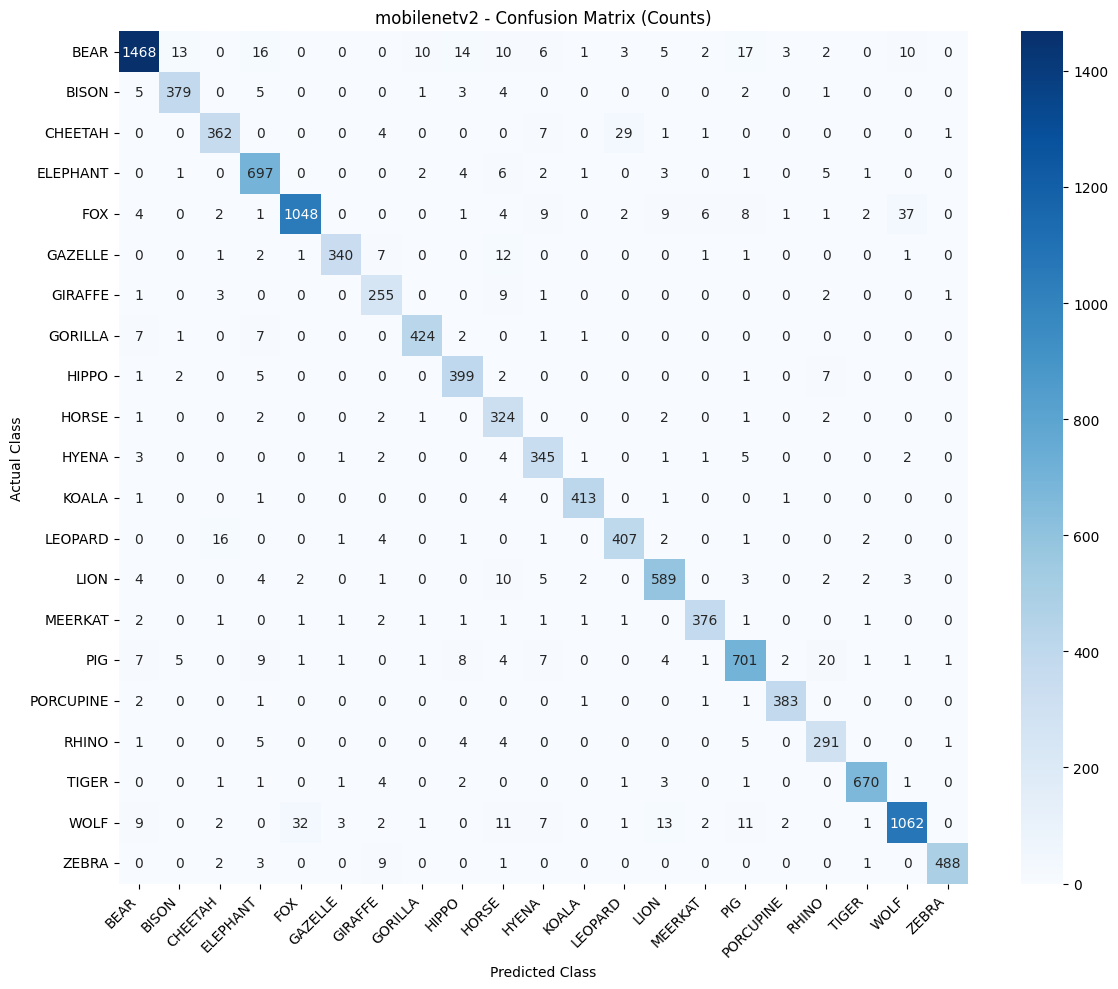

Normalized confusion matrix plot saved to /kaggle/working/module_3_outputs/mobilenetv2_confusion_matrix_normalized.png


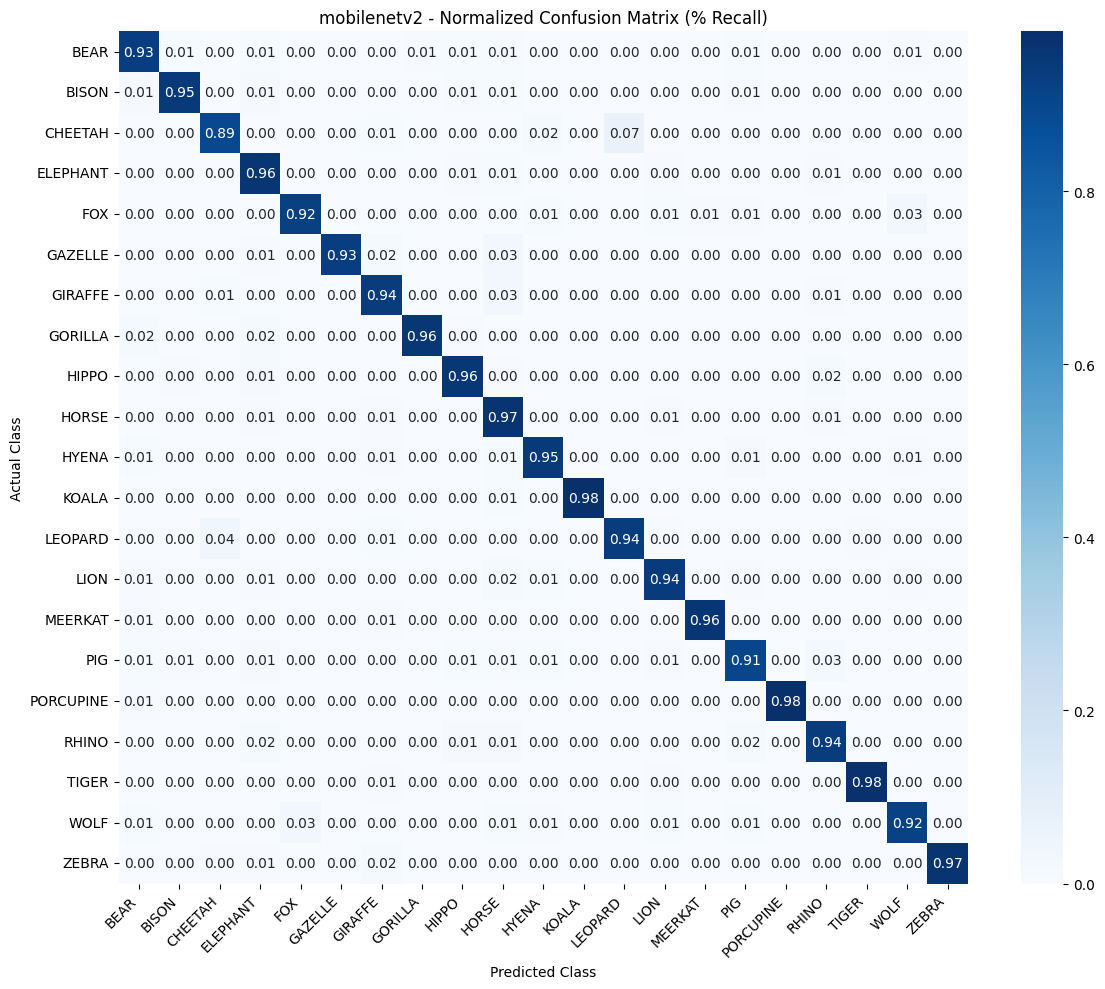

In [24]:
print(f"\n--- Generating Confusion Matrix for {MODEL_NAME_M2} ---")

if y_pred_m2 is not None and y_true_m2 is not None:
    # Calculate confusion matrix
    cm_m2 = confusion_matrix(y_true_m2, y_pred_m2)

    # --- Plot Raw Confusion Matrix ---
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_m2, annot=True, fmt="d", cmap="Blues",
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f'{MODEL_NAME_M2} - Confusion Matrix (Counts)')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(CM_SAVE_PATH_M2) # Save the plot
    print(f"Raw confusion matrix plot saved to {CM_SAVE_PATH_M2}")
    plt.show()


    # --- Plot Normalized Confusion Matrix (by True Class / Recall) ---
    cm_m2_normalized = cm_m2.astype('float') / cm_m2.sum(axis=1)[:, np.newaxis]
    # Handle potential NaN values if a class has no true samples in the test set
    cm_m2_normalized = np.nan_to_num(cm_m2_normalized, nan=0.0)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_m2_normalized, annot=True, fmt=".2f", cmap="Blues", # Use float format
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f'{MODEL_NAME_M2} - Normalized Confusion Matrix (% Recall)')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(CM_NORM_SAVE_PATH_M2) # Save the plot
    print(f"Normalized confusion matrix plot saved to {CM_NORM_SAVE_PATH_M2}")
    plt.show()

else:
    print("Predictions or true labels not available. Skipping confusion matrix.")

In [25]:
print(f"\n--- Module 3 Evaluation Summary ({MODEL_NAME_M2}) ---")
print(f"1. Loaded best saved {MODEL_NAME_M2} model from {MODEL_PATH_M2}.")
print(f"2. Prepared test data generator with appropriate preprocessing.")
if loaded_model_m2 is not None and 'results_m2' in locals():
    print(f"3. Evaluated model on test set: Loss={results_m2[0]:.4f}, Accuracy={results_m2[1]*100:.2f}%.")
if y_pred_proba_m2 is not None:
    print(f"4. Generated predictions and extracted true labels.")
    print(f"5. Printed classification report (Precision, Recall, F1-Score per class).")
    print(f"6. Generated and saved confusion matrices (raw counts and normalized) to {MODULE_3_OUTPUT_DIR}.")
else:
     print("Evaluation skipped due to model loading or prediction issues.")
print(f"\nEvaluation for {MODEL_NAME_M2} complete.")


--- Module 3 Evaluation Summary (mobilenetv2) ---
1. Loaded best saved mobilenetv2 model from /kaggle/input/cvml-proj/module_2_outputs/mobilenetv2_tfdata_best.keras.
2. Prepared test data generator with appropriate preprocessing.
3. Evaluated model on test set: Loss=0.1897, Accuracy=94.10%.
4. Generated predictions and extracted true labels.
5. Printed classification report (Precision, Recall, F1-Score per class).
6. Generated and saved confusion matrices (raw counts and normalized) to /kaggle/working/module_3_outputs.

Evaluation for mobilenetv2 complete.


### ResNet 50

In [26]:
# --- ResNet50 Specific Imports ---
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
# ImageDataGenerator should already be imported, but ensure it is
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Ensure sklearn, numpy, os, plt, seaborn etc. are imported from common setup

print("\n--- Setting up for ResNet50 Evaluation ---")

# --- Specific files for ResNet50 ---
MODEL_NAME_R50 = 'resnet50'
MODULE_2_OUTPUTS_IN = os.path.join(PREVIOUS_NOTEBOOK_OUTPUT_BASE, 'module_2_outputs') # Assumes PREVIOUS_NOTEBOOK_OUTPUT_BASE is defined
MODEL_PATH_R50 = os.path.join(MODULE_2_OUTPUTS_IN, f'{MODEL_NAME_R50}_tfdata_best.keras')
HISTORY_PATH_R50 = os.path.join(MODULE_2_OUTPUTS_IN, f'{MODEL_NAME_R50}_tfdata_history.pkl') # Optional history path

# --- Output paths for ResNet50 results ---
CM_SAVE_PATH_R50 = os.path.join(MODULE_3_OUTPUT_DIR, f'{MODEL_NAME_R50}_confusion_matrix.png') # Assumes MODULE_3_OUTPUT_DIR is defined
CM_NORM_SAVE_PATH_R50 = os.path.join(MODULE_3_OUTPUT_DIR, f'{MODEL_NAME_R50}_confusion_matrix_normalized.png')
REPORT_SAVE_PATH_R50 = os.path.join(MODULE_3_OUTPUT_DIR, f'{MODEL_NAME_R50}_classification_report.txt')

print(f"Model Path: {MODEL_PATH_R50}")


--- Setting up for ResNet50 Evaluation ---
Model Path: /kaggle/input/cvml-proj/module_2_outputs/resnet50_tfdata_best.keras


In [27]:
print(f"\n--- Loading Trained {MODEL_NAME_R50} Model ---")

loaded_model_r50 = None
try:
    loaded_model_r50 = tf.keras.models.load_model(MODEL_PATH_R50)
    print(f"{MODEL_NAME_R50} model loaded successfully!")
    # loaded_model_r50.summary() # Optional: Uncomment to verify
except Exception as e:
    print(f"Error loading model from {MODEL_PATH_R50}: {e}")


--- Loading Trained resnet50 Model ---
resnet50 model loaded successfully!


In [28]:
print(f"\n--- Preparing Test Data Generator for {MODEL_NAME_R50} ---")

test_datagen_r50 = ImageDataGenerator(
    preprocessing_function=resnet50_preprocess_input # Use ResNet50 preprocessing
)

# Assumes TEST_DIR, TARGET_SIZE, BATCH_SIZE, CLASSES are defined
test_generator_r50 = test_datagen_r50.flow_from_directory(
    TEST_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES,
    shuffle=False
)

print(f"Found {test_generator_r50.samples} test images.")
if test_generator_r50.samples == 0:
     print(f"ERROR: Test generator found 0 samples in {TEST_DIR}.")


--- Preparing Test Data Generator for resnet50 ---
Found 12137 images belonging to 21 classes.
Found 12137 test images.


In [29]:
print(f"\n--- Evaluating {MODEL_NAME_R50} on Test Data ---")

results_r50 = None
if loaded_model_r50 is not None and test_generator_r50.samples > 0:
    try:
        test_generator_r50.reset()
        results_r50 = loaded_model_r50.evaluate(
            test_generator_r50,
            steps=len(test_generator_r50),
            verbose=1
        )
        print("\n--- Test Set Evaluation Results ---")
        print(f"Test Loss:      {results_r50[0]:.4f}")
        print(f"Test Accuracy:  {results_r50[1]*100:.2f}%")
        if len(results_r50) > 2: # Check if top-5 was compiled
            print(f"Test Top-5 Acc: {results_r50[2]*100:.2f}%")
    except Exception as e:
         print(f"An error occurred during model.evaluate: {e}")
else:
    print("Model not loaded or test generator empty. Skipping evaluation.")


--- Evaluating resnet50 on Test Data ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


380/380 ━━━━━━━━━━━━━━━━━━━━ 52s 111ms/step - accuracy: 0.9414 - loss: 0.1912 - top_5_accuracy: 0.9948

--- Test Set Evaluation Results ---
Test Loss:      0.1860
Test Accuracy:  94.50%
Test Top-5 Acc: 99.48%


In [30]:
print(f"\n--- Generating Predictions for {MODEL_NAME_R50} ---")

y_pred_proba_r50 = None
if loaded_model_r50 is not None and test_generator_r50.samples > 0:
    test_generator_r50.reset()
    y_pred_proba_r50 = loaded_model_r50.predict(
        test_generator_r50,
        steps=len(test_generator_r50),
        verbose=1
    )
    print(f"Predictions generated. Shape: {y_pred_proba_r50.shape}")
else:
    print("Model not loaded or test generator empty. Skipping prediction generation.")


--- Generating Predictions for resnet50 ---
380/380 ━━━━━━━━━━━━━━━━━━━━ 46s 109ms/step
Predictions generated. Shape: (12137, 21)


In [31]:
print("\n--- Extracting True & Predicted Labels ---")

y_true_r50 = None
y_pred_r50 = None
if test_generator_r50.samples > 0:
    y_true_r50 = test_generator_r50.classes
    print(f"True labels extracted. Shape: {y_true_r50.shape}")
    if y_pred_proba_r50 is not None:
        if len(y_true_r50) == y_pred_proba_r50.shape[0]:
            y_pred_r50 = np.argmax(y_pred_proba_r50, axis=1)
            print(f"Predicted labels generated. Shape: {y_pred_r50.shape}")
        else:
            print(f"WARNING: Label count ({len(y_true_r50)}) mismatch with predictions ({y_pred_proba_r50.shape[0]})!")
else:
    print("Test generator empty. Cannot extract labels.")


--- Extracting True & Predicted Labels ---
True labels extracted. Shape: (12137,)
Predicted labels generated. Shape: (12137,)


In [32]:
print(f"\n--- Generating Classification Report for {MODEL_NAME_R50} ---")

if y_pred_r50 is not None and y_true_r50 is not None:
    print("\nClassification Report:")
    try:
        # Use zero_division=0 to handle classes with no support (like 'HORRSE')
        report_r50 = classification_report(y_true_r50, y_pred_r50, target_names=CLASSES, digits=3, zero_division=0)
        print(report_r50)
        # Save report
        with open(REPORT_SAVE_PATH_R50, 'w') as f:
            f.write(report_r50)
        print(f"Classification report saved to {REPORT_SAVE_PATH_R50}")
    except Exception as e:
        print(f"Error generating classification report: {e}")
else:
    print("Predictions or true labels not available. Skipping classification report.")


--- Generating Classification Report for resnet50 ---

Classification Report:
              precision    recall  f1-score   support

        BEAR      0.971     0.939     0.955      1580
       BISON      0.901     0.960     0.930       400
     CHEETAH      0.910     0.879     0.894       405
    ELEPHANT      0.968     0.950     0.959       723
         FOX      0.947     0.937     0.942      1135
     GAZELLE      0.945     0.937     0.941       366
     GIRAFFE      0.931     0.949     0.940       272
     GORILLA      0.950     0.991     0.970       443
       HIPPO      0.900     0.969     0.933       417
       HORSE      0.885     0.967     0.924       335
       HYENA      0.916     0.932     0.924       365
       KOALA      0.956     0.988     0.972       421
     LEOPARD      0.899     0.938     0.918       435
        LION      0.953     0.941     0.947       627
     MEERKAT      0.967     0.964     0.965       391
         PIG      0.904     0.912     0.908       774
  


--- Generating Confusion Matrix for resnet50 ---


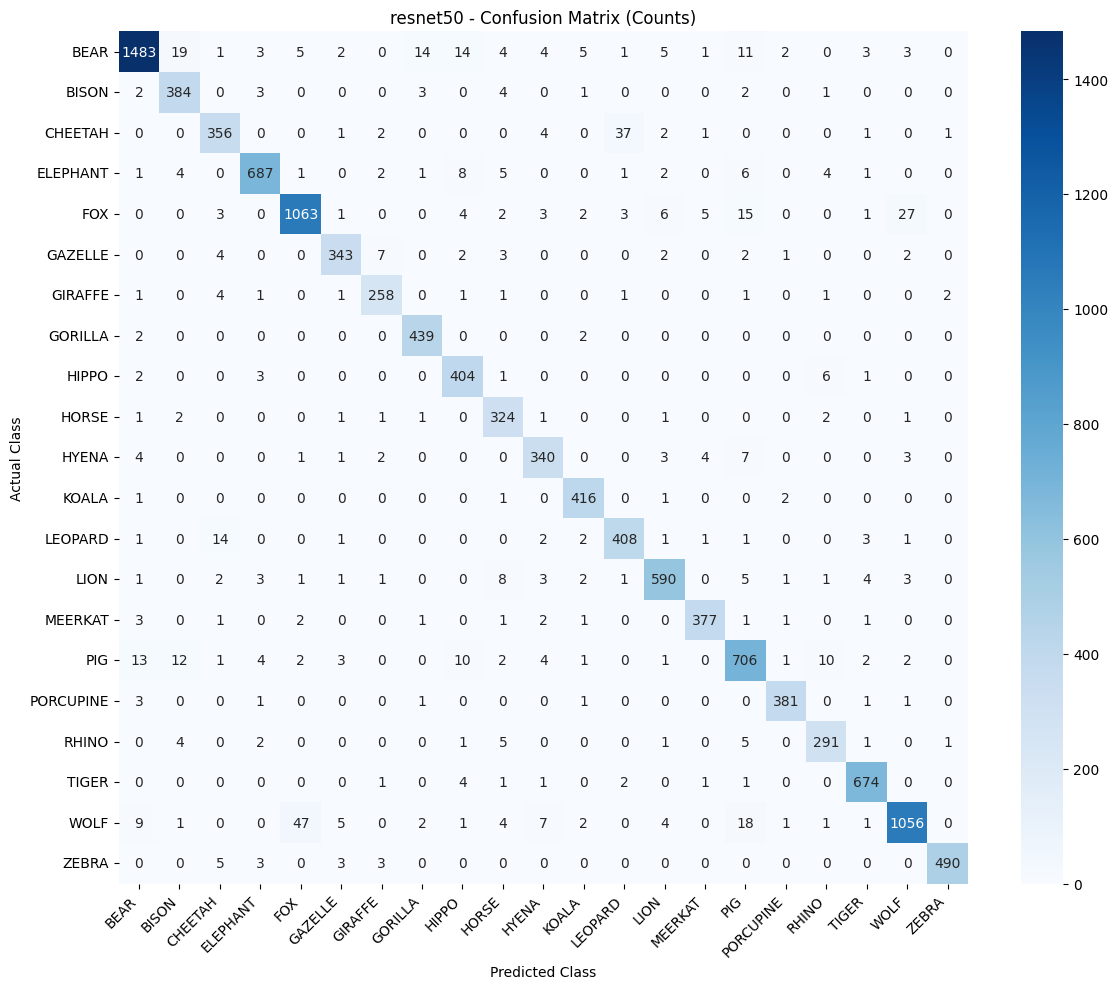

Raw confusion matrix plot saved to /kaggle/working/module_3_outputs/resnet50_confusion_matrix.png


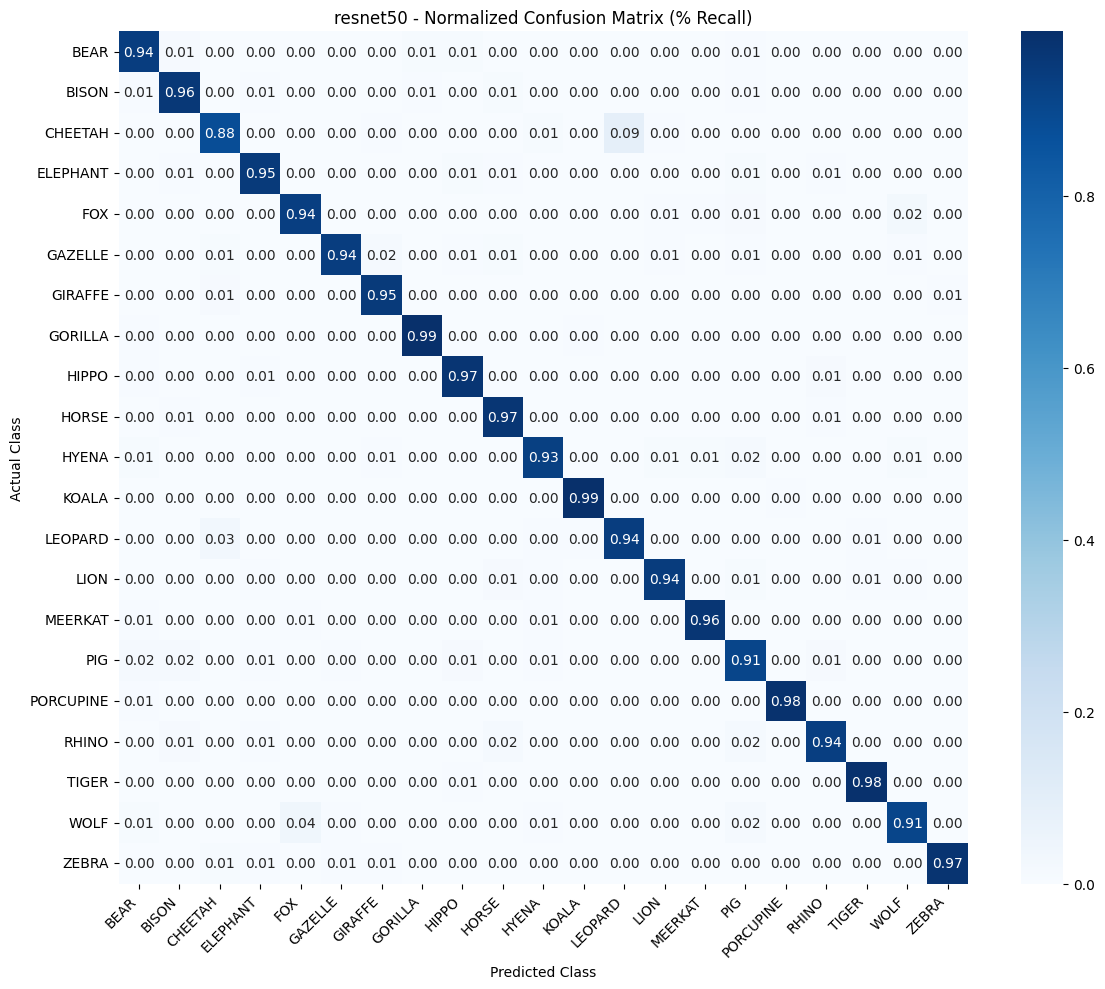

Normalized confusion matrix plot saved to /kaggle/working/module_3_outputs/resnet50_confusion_matrix_normalized.png


In [33]:
print(f"\n--- Generating Confusion Matrix for {MODEL_NAME_R50} ---")

if y_pred_r50 is not None and y_true_r50 is not None:
    cm_r50 = confusion_matrix(y_true_r50, y_pred_r50)

    # Plot Raw Confusion Matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_r50, annot=True, fmt="d", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f'{MODEL_NAME_R50} - Confusion Matrix (Counts)')
    plt.ylabel('Actual Class'); plt.xlabel('Predicted Class')
    plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
    plt.tight_layout(); plt.savefig(CM_SAVE_PATH_R50); plt.show()
    print(f"Raw confusion matrix plot saved to {CM_SAVE_PATH_R50}")

    # Plot Normalized Confusion Matrix
    cm_r50_normalized = cm_r50.astype('float') / cm_r50.sum(axis=1)[:, np.newaxis]
    cm_r50_normalized = np.nan_to_num(cm_r50_normalized, nan=0.0)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_r50_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f'{MODEL_NAME_R50} - Normalized Confusion Matrix (% Recall)')
    plt.ylabel('Actual Class'); plt.xlabel('Predicted Class')
    plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
    plt.tight_layout(); plt.savefig(CM_NORM_SAVE_PATH_R50); plt.show()
    print(f"Normalized confusion matrix plot saved to {CM_NORM_SAVE_PATH_R50}")

else:
    print("Predictions or true labels not available. Skipping confusion matrix.")

In [34]:
print(f"\n--- Module 3 Evaluation Summary ({MODEL_NAME_R50}) ---")
# (Same summary structure as before, just referencing ResNet50 variables)
if results_r50 is not None:
    print(f"Evaluated {MODEL_NAME_R50} on test set: Loss={results_r50[0]:.4f}, Accuracy={results_r50[1]*100:.2f}%.")
if y_pred_r50 is not None:
    print(f"Generated classification report (saved to {REPORT_SAVE_PATH_R50}).")
    print(f"Generated confusion matrices (saved to {MODULE_3_OUTPUT_DIR}).")
else:
     print(f"Evaluation skipped or incomplete for {MODEL_NAME_R50}.")
print(f"\nEvaluation for {MODEL_NAME_R50} complete.")


--- Module 3 Evaluation Summary (resnet50) ---
Evaluated resnet50 on test set: Loss=0.1860, Accuracy=94.50%.
Generated classification report (saved to /kaggle/working/module_3_outputs/resnet50_classification_report.txt).
Generated confusion matrices (saved to /kaggle/working/module_3_outputs).

Evaluation for resnet50 complete.


### ConvNext Base

In [35]:
# --- ConvNeXt Specific Imports ---
from tensorflow.keras.applications.convnext import preprocess_input as convnext_preprocess_input
# Ensure ImageDataGenerator is imported from common setup
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("\n--- Setting up for ConvNeXt Base Evaluation ---")

# --- Specific files for ConvNeXt Base ---
MODEL_NAME_CNB = 'convnext_base' # Define model name
MODULE_2_OUTPUTS_IN = os.path.join(PREVIOUS_NOTEBOOK_OUTPUT_BASE, 'module_2_outputs') # Assumes PREVIOUS_NOTEBOOK_OUTPUT_BASE is defined
MODEL_PATH_CNB = os.path.join(MODULE_2_OUTPUTS_IN, f'{MODEL_NAME_CNB}_tfdata_best.keras')
HISTORY_PATH_CNB = os.path.join(MODULE_2_OUTPUTS_IN, f'{MODEL_NAME_CNB}_tfdata_history.pkl') # Optional history path

# --- Output paths for ConvNeXt Base results ---
CM_SAVE_PATH_CNB = os.path.join(MODULE_3_OUTPUT_DIR, f'{MODEL_NAME_CNB}_confusion_matrix.png') # Assumes MODULE_3_OUTPUT_DIR is defined
CM_NORM_SAVE_PATH_CNB = os.path.join(MODULE_3_OUTPUT_DIR, f'{MODEL_NAME_CNB}_confusion_matrix_normalized.png')
REPORT_SAVE_PATH_CNB = os.path.join(MODULE_3_OUTPUT_DIR, f'{MODEL_NAME_CNB}_classification_report.txt')

print(f"Model Path: {MODEL_PATH_CNB}")


--- Setting up for ConvNeXt Base Evaluation ---
Model Path: /kaggle/input/cvml-proj/module_2_outputs/convnext_base_tfdata_best.keras


In [36]:
print(f"\n--- Loading Trained {MODEL_NAME_CNB} Model ---")

loaded_model_cnb = None
try:
    loaded_model_cnb = tf.keras.models.load_model(MODEL_PATH_CNB)
    print(f"{MODEL_NAME_CNB} model loaded successfully!")
    # loaded_model_cnb.summary() # Optional: Uncomment to verify
except Exception as e:
    print(f"Error loading model from {MODEL_PATH_CNB}: {e}")


--- Loading Trained convnext_base Model ---
convnext_base model loaded successfully!


In [37]:
print(f"\n--- Preparing Test Data Generator for {MODEL_NAME_CNB} ---")

test_datagen_cnb = ImageDataGenerator(
    preprocessing_function=convnext_preprocess_input # Use ConvNeXt preprocessing
)

# Assumes TEST_DIR, TARGET_SIZE, BATCH_SIZE, CLASSES are defined
test_generator_cnb = test_datagen_cnb.flow_from_directory(
    TEST_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES,
    shuffle=False
)

print(f"Found {test_generator_cnb.samples} test images.")
if test_generator_cnb.samples == 0:
     print(f"ERROR: Test generator found 0 samples in {TEST_DIR}.")


--- Preparing Test Data Generator for convnext_base ---
Found 12137 images belonging to 21 classes.
Found 12137 test images.


In [38]:
print(f"\n--- Evaluating {MODEL_NAME_CNB} on Test Data ---")

results_cnb = None
if loaded_model_cnb is not None and test_generator_cnb.samples > 0:
    try:
        test_generator_cnb.reset()
        results_cnb = loaded_model_cnb.evaluate(
            test_generator_cnb,
            steps=len(test_generator_cnb),
            verbose=1
        )
        print("\n--- Test Set Evaluation Results ---")
        print(f"Test Loss:      {results_cnb[0]:.4f}")
        print(f"Test Accuracy:  {results_cnb[1]*100:.2f}%")
        if len(results_cnb) > 2: # Check if top-5 was compiled
            print(f"Test Top-5 Acc: {results_cnb[2]*100:.2f}%")
    except Exception as e:
         print(f"An error occurred during model.evaluate: {e}")
else:
    print("Model not loaded or test generator empty. Skipping evaluation.")


--- Evaluating convnext_base on Test Data ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
E0000 00:00:1744749642.699816      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744749642.838795      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744749642.976804      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


379/380 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.8317 - loss: 0.5435 - top_5_accuracy: 0.9726

E0000 00:00:1744749810.487918      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744749810.626681      95 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


380/380 ━━━━━━━━━━━━━━━━━━━━ 180s 439ms/step - accuracy: 0.8318 - loss: 0.5434 - top_5_accuracy: 0.9726

--- Test Set Evaluation Results ---
Test Loss:      0.5308
Test Accuracy:  83.79%
Test Top-5 Acc: 96.79%


In [39]:
print(f"\n--- Generating Predictions for {MODEL_NAME_CNB} ---")

y_pred_proba_cnb = None
if loaded_model_cnb is not None and test_generator_cnb.samples > 0:
    test_generator_cnb.reset()
    y_pred_proba_cnb = loaded_model_cnb.predict(
        test_generator_cnb,
        steps=len(test_generator_cnb),
        verbose=1
    )
    print(f"Predictions generated. Shape: {y_pred_proba_cnb.shape}")
else:
    print("Model not loaded or test generator empty. Skipping prediction generation.")


--- Generating Predictions for convnext_base ---
380/380 ━━━━━━━━━━━━━━━━━━━━ 173s 440ms/step
Predictions generated. Shape: (12137, 21)


In [40]:
print("\n--- Extracting True & Predicted Labels ---")

y_true_cnb = None
y_pred_cnb = None
if test_generator_cnb.samples > 0:
    y_true_cnb = test_generator_cnb.classes
    print(f"True labels extracted. Shape: {y_true_cnb.shape}")
    if y_pred_proba_cnb is not None:
        if len(y_true_cnb) == y_pred_proba_cnb.shape[0]:
            y_pred_cnb = np.argmax(y_pred_proba_cnb, axis=1)
            print(f"Predicted labels generated. Shape: {y_pred_cnb.shape}")
        else:
            print(f"WARNING: Label count ({len(y_true_cnb)}) mismatch with predictions ({y_pred_proba_cnb.shape[0]})!")
else:
    print("Test generator empty. Cannot extract labels.")


--- Extracting True & Predicted Labels ---
True labels extracted. Shape: (12137,)
Predicted labels generated. Shape: (12137,)


In [41]:
print(f"\n--- Generating Classification Report for {MODEL_NAME_CNB} ---")

if y_pred_cnb is not None and y_true_cnb is not None:
    print("\nClassification Report:")
    try:
        # Use zero_division=0 to handle classes with no support (like 'HORRSE')
        report_cnb = classification_report(y_true_cnb, y_pred_cnb, target_names=CLASSES, digits=3, zero_division=0)
        print(report_cnb)
        # Save report
        with open(REPORT_SAVE_PATH_CNB, 'w') as f:
            f.write(report_cnb)
        print(f"Classification report saved to {REPORT_SAVE_PATH_CNB}")
    except Exception as e:
        print(f"Error generating classification report: {e}")
else:
    print("Predictions or true labels not available. Skipping classification report.")


--- Generating Classification Report for convnext_base ---

Classification Report:
              precision    recall  f1-score   support

        BEAR      0.816     0.839     0.827      1580
       BISON      0.854     0.848     0.851       400
     CHEETAH      0.834     0.758     0.794       405
    ELEPHANT      0.781     0.864     0.821       723
         FOX      0.850     0.802     0.825      1135
     GAZELLE      0.923     0.847     0.883       366
     GIRAFFE      0.960     0.886     0.922       272
     GORILLA      0.870     0.813     0.840       443
       HIPPO      0.787     0.806     0.796       417
       HORSE      0.916     0.907     0.912       335
       HYENA      0.775     0.756     0.766       365
       KOALA      0.832     0.931     0.879       421
     LEOPARD      0.841     0.839     0.840       435
        LION      0.848     0.817     0.832       627
     MEERKAT      0.913     0.803     0.854       391
         PIG      0.644     0.782     0.706       7


--- Generating Confusion Matrix for convnext_base ---


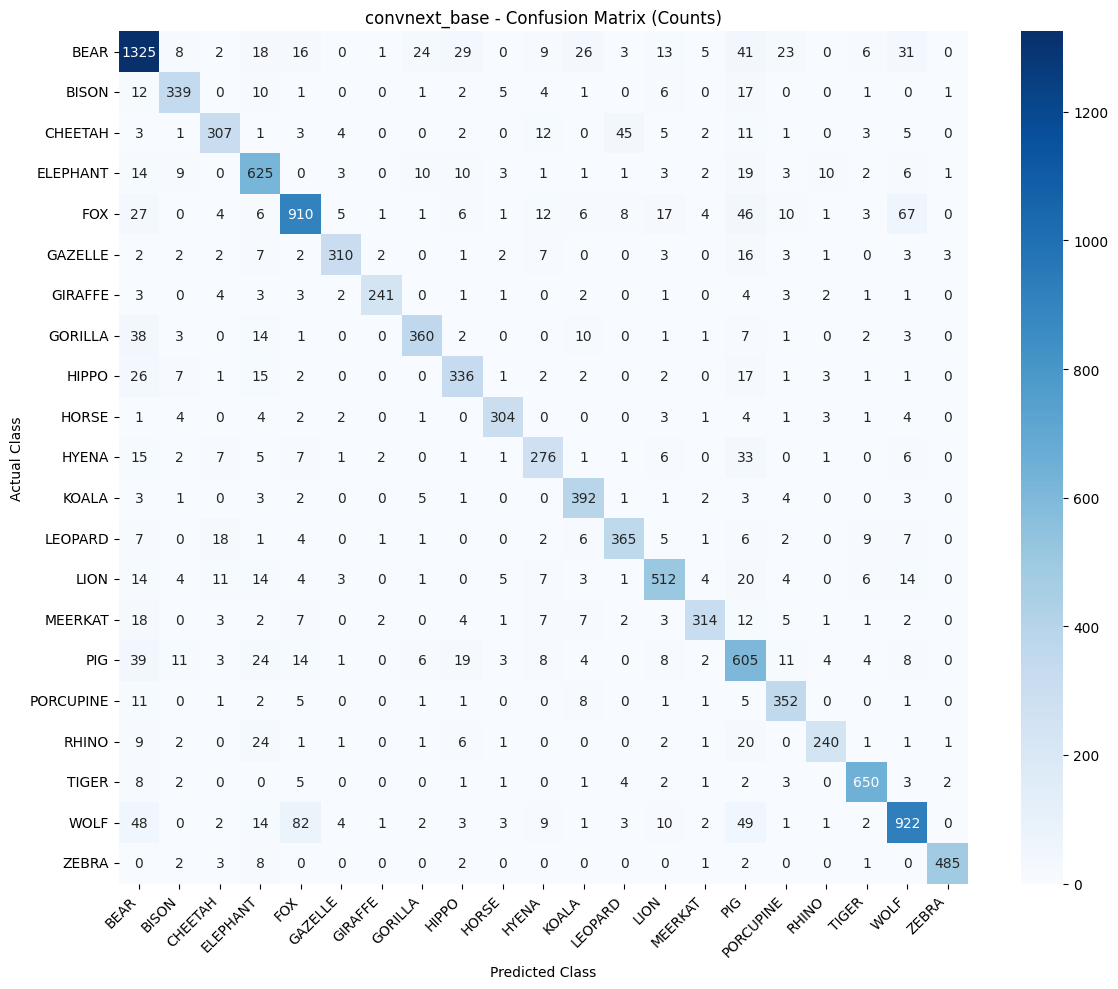

Raw confusion matrix plot saved to /kaggle/working/module_3_outputs/convnext_base_confusion_matrix.png


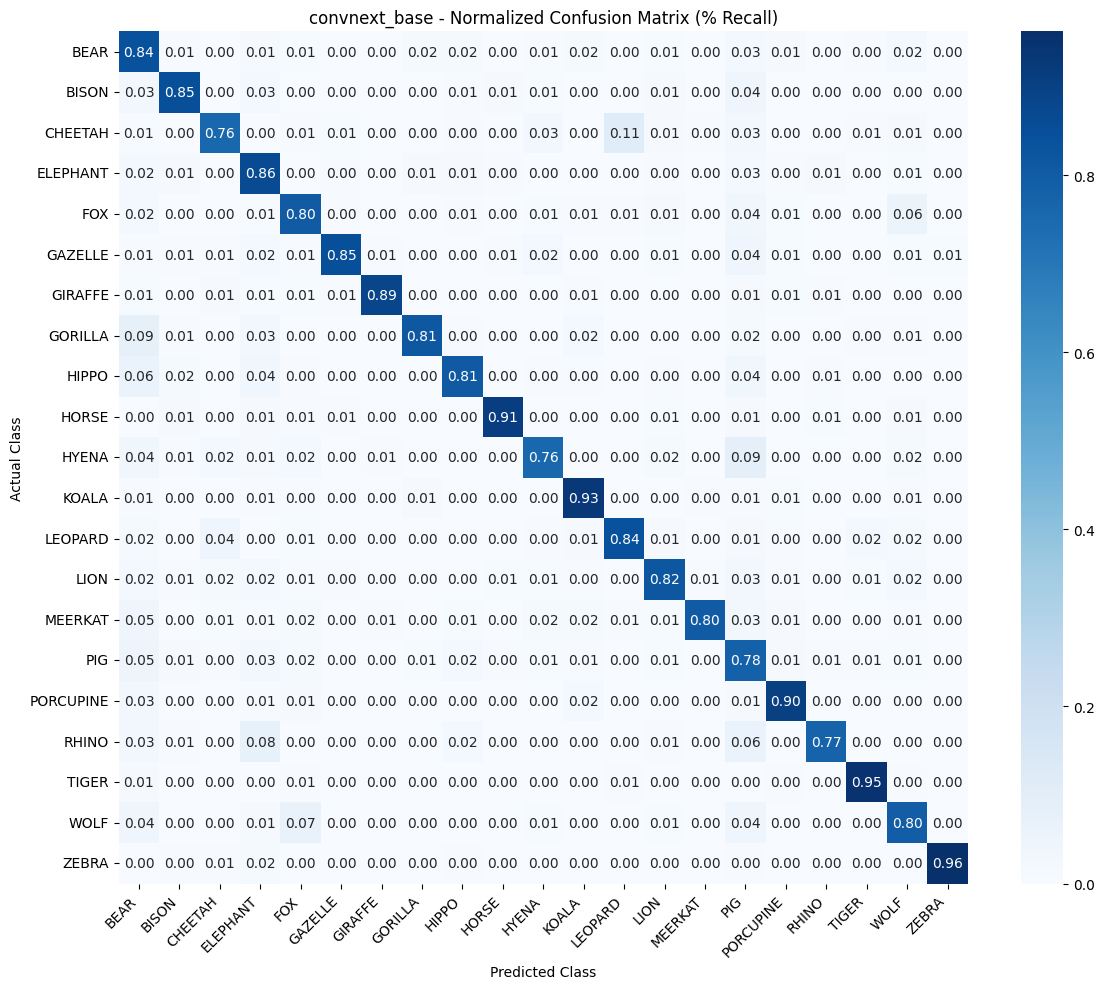

Normalized confusion matrix plot saved to /kaggle/working/module_3_outputs/convnext_base_confusion_matrix_normalized.png


In [42]:
print(f"\n--- Generating Confusion Matrix for {MODEL_NAME_CNB} ---")

if y_pred_cnb is not None and y_true_cnb is not None:
    cm_cnb = confusion_matrix(y_true_cnb, y_pred_cnb)

    # Plot Raw Confusion Matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_cnb, annot=True, fmt="d", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f'{MODEL_NAME_CNB} - Confusion Matrix (Counts)')
    plt.ylabel('Actual Class'); plt.xlabel('Predicted Class')
    plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
    plt.tight_layout(); plt.savefig(CM_SAVE_PATH_CNB); plt.show()
    print(f"Raw confusion matrix plot saved to {CM_SAVE_PATH_CNB}")

    # Plot Normalized Confusion Matrix
    cm_cnb_normalized = cm_cnb.astype('float') / cm_cnb.sum(axis=1)[:, np.newaxis]
    cm_cnb_normalized = np.nan_to_num(cm_cnb_normalized, nan=0.0)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_cnb_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(f'{MODEL_NAME_CNB} - Normalized Confusion Matrix (% Recall)')
    plt.ylabel('Actual Class'); plt.xlabel('Predicted Class')
    plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
    plt.tight_layout(); plt.savefig(CM_NORM_SAVE_PATH_CNB); plt.show()
    print(f"Normalized confusion matrix plot saved to {CM_NORM_SAVE_PATH_CNB}")

else:
    print("Predictions or true labels not available. Skipping confusion matrix.")

In [43]:
print(f"\n--- Module 3 Evaluation Summary ({MODEL_NAME_CNB}) ---")
# (Same summary structure as before, just referencing ConvNeXt variables)
if results_cnb is not None:
    print(f"Evaluated {MODEL_NAME_CNB} on test set: Loss={results_cnb[0]:.4f}, Accuracy={results_cnb[1]*100:.2f}%.")
if y_pred_cnb is not None:
    print(f"Generated classification report (saved to {REPORT_SAVE_PATH_CNB}).")
    print(f"Generated confusion matrices (saved to {MODULE_3_OUTPUT_DIR}).")
else:
     print(f"Evaluation skipped or incomplete for {MODEL_NAME_CNB}.")
print(f"\nEvaluation for {MODEL_NAME_CNB} complete.")


--- Module 3 Evaluation Summary (convnext_base) ---
Evaluated convnext_base on test set: Loss=0.5308, Accuracy=83.79%.
Generated classification report (saved to /kaggle/working/module_3_outputs/convnext_base_classification_report.txt).
Generated confusion matrices (saved to /kaggle/working/module_3_outputs).

Evaluation for convnext_base complete.
